In [1]:
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv('../data/FPT.csv')

# ARIMA

In [3]:
def process_data_arima(data):
    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    # Lấy chuỗi thời gian giá 'close'
    data = np.log(data['close'])

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    train, test = train_test_split(data, test_size=0.2, shuffle=False)

    return train, test

In [4]:
train, test = process_data_arima(data)

In [3]:
import pickle

with open('../model/ARIMA-FPT.pkl', 'rb') as f:
    model = pickle.load(f)


In [6]:
forecast = model.predict(n_periods=len(test))

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# GRU

In [7]:
def process_data(data):
    # Đảm bảo residuals là numpy array 2D
    # if isinstance(residuals, pd.Series):
    #     residuals = residuals.values.reshape(-1, 1)
    # elif isinstance(residuals, np.ndarray) and residuals.ndim == 1:
    #     residuals = residuals.reshape(-1, 1)

    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    #Lấy cột Close
    data=data[['close']]

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    x_train, x_test = train_test_split(data, test_size=0.2, shuffle=False)

    # Khởi tạo scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit scaler trên tập huấn luyện và transform cả train lẫn test
    train_scaled = scaler.fit_transform(x_train)
    test_scaled = scaler.transform(x_test)

    #Tạo vòng lặp giá trị, lấy 60 ngày trong quá khứ để dự đoán ngày tiếp theo
    x_train = []
    y_train = []
    for i in range(60, len(train_scaled)):
        x_train.append(train_scaled[i-60:i, 0])
        y_train.append(train_scaled[i, 0])

    x_test = []
    y_test = []
    for i in range(60, len(test_scaled)):
        x_test.append(test_scaled[i-60:i, 0])
        y_test.append(test_scaled[i, 0])

    #Chuyển dạng list sang dạng mảng numpy
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    #Xếp dữ liệu thành mảng 1 chiều
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, scaler, test_scaled

In [8]:
x_train, y_train, x_test, y_test, scaler, test_scaled = process_data(data)

In [4]:
model_gru = load_model("../model/GRU-FPT-128.h5", compile=False)

In [ ]:
predict = model_gru.predict(x_test)
prediction_test_price = scaler.inverse_transform(predict)
actual_test_price = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step


# ARIMA-GRU

In [ ]:
# Giữ dữ liệu ARIMA ở dạng chuẩn hóa (không exp)
arima_pred_scaled = forecast   
arima_true_scaled = test       

# GRU  dữ liệu scaled, chưa inverse
gru_pred_scaled = predict.reshape(-1)
gru_true_scaled = y_test.reshape(-1)

# Cắt độ dài cho khớp
min_len = min(len(arima_true_scaled), len(gru_true_scaled))
arima_pred_scaled = arima_pred_scaled[:min_len]
gru_pred_scaled = gru_pred_scaled[:min_len]
y_true_scaled = gru_true_scaled[:min_len]

In [ ]:
# Tính alpha tối ưu
def compute_optimal_alpha(y_true, y_arima, y_gru):
    numerator = np.sum((y_arima - y_gru) * (y_true - y_gru))
    denominator = np.sum((y_arima - y_gru) ** 2)
    alpha = numerator / denominator if denominator != 0 else 0
    return max(0, min(1, alpha))

In [ ]:
alpha = compute_optimal_alpha(y_true_scaled, arima_pred_scaled, gru_pred_scaled)
combined_pred_scaled = alpha * arima_pred_scaled + (1 - alpha) * gru_pred_scaled

In [14]:
alpha

1

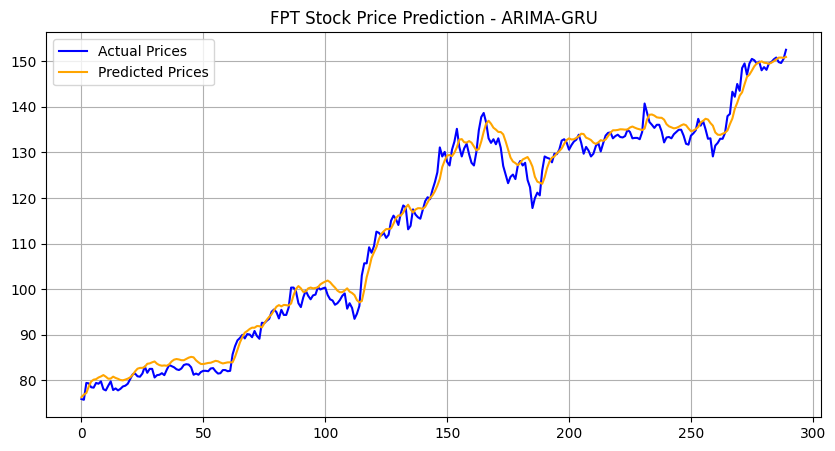

In [30]:
#alpha: 1
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('FPT Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
#FPT
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.043330158319593935
MAE: 0.03430550221633801
R-squared: 0.9879964137146877


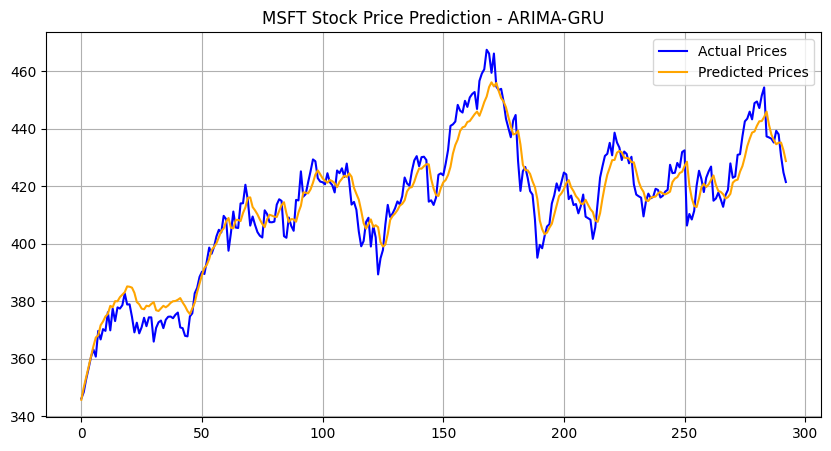

In [60]:
#alpha: 0.9982854749356194
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('MSFT Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
#MSFT
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.02330663905919472
MAE: 0.01866559618173676
R-squared: 0.9292608246972234


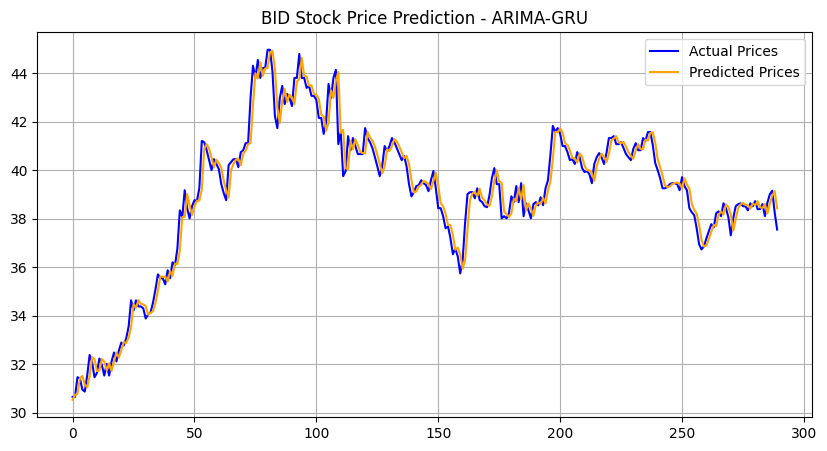

In [15]:
#alpha: 0.9960779414366033
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('BID Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#BID
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.024118773758166793
MAE: 0.017607173183796163
R-squared: 0.9632942825583547


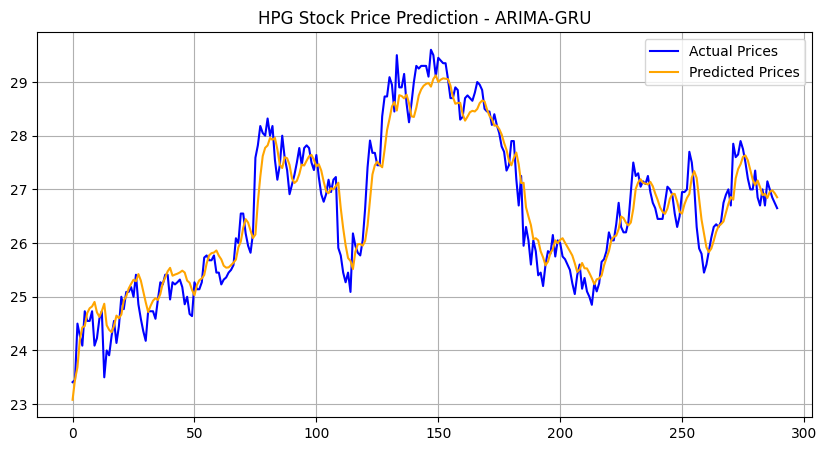

In [45]:
#alpha: 1
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('HPG Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
#HPG
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.012472551711663183
MAE: 0.009570521997325783
R-squared: 0.9174224261250428


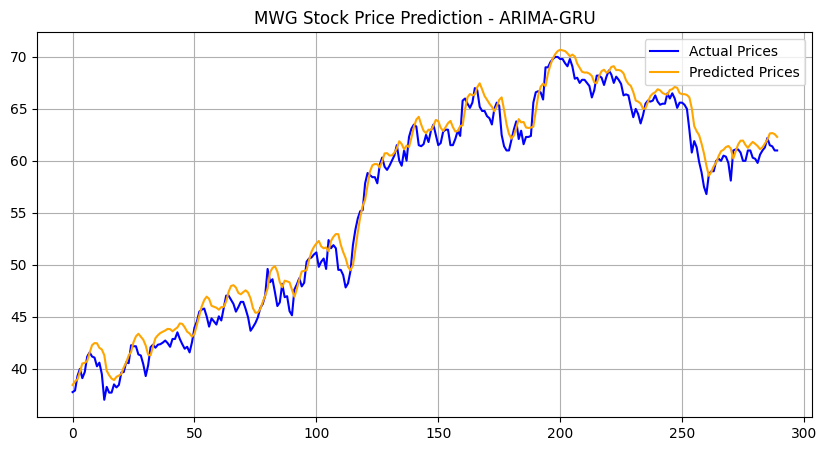

In [15]:
#alpha: 1
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('MWG Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#MWG
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.024177600375859653
MAE: 0.01977601935345177
R-squared: 0.9792176911442254


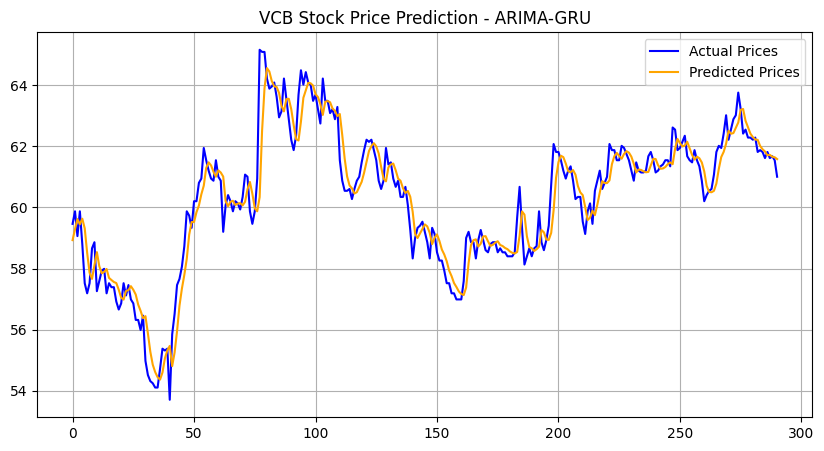

In [75]:
#alpha: 0.9949619523206349
x_range = np.arange(len(y_true_scaled))  # từ 0 đến 290

plt.figure(figsize=(10,5))
plt.plot(x_range, scaler.inverse_transform(y_true_scaled.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(x_range, scaler.inverse_transform(combined_pred_scaled.values.reshape(-1, 1)), label='Predicted Prices', color='orange')
plt.title('VCB Stock Price Prediction - ARIMA-GRU')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
#VCB
rmse = np.sqrt(mean_squared_error(y_true_scaled, combined_pred_scaled))
mae = mean_absolute_error(y_true_scaled, combined_pred_scaled)
r2 = r2_score(y_true_scaled, combined_pred_scaled)

print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

RMSE: 0.016855563510799077
MAE: 0.011972364869446063
R-squared: 0.898728004658582
